In [4]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [5]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [6]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [7]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [8]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [9]:
# View all of the classes that automap found
for table_name in Base.classes.keys():
    print(table_name)

measurement
station


In [10]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [12]:
# Find the most recent date in the data set.
most_recent_data=session.query(func.max(Measurement.date)).scalar()
print(most_recent_data)

2017-08-23


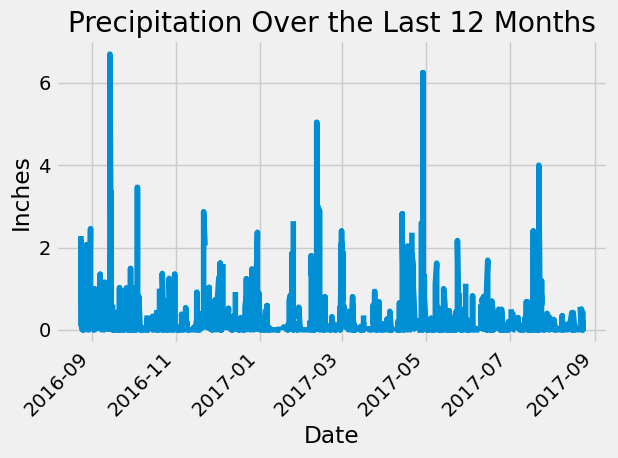

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database.
most_recent_data = session.query(func.max(Measurement.date)).scalar()

    
    # Calculate the date one year from the last date in dataset
one_year_ago = dt.datetime.strptime(most_recent_data, "%Y-%m-%d") - dt.timedelta(days=365)
precipitation_data = session.query(Measurement.date, Measurement.prcp)\
    .filter(Measurement.date >= one_year_ago)\
    .order_by(Measurement.date).all()
    # Perform a query to retrieve the date and precipitation scores
    
    # Save the query results as a Pandas DataFrame, setting the column names explicitly
df = pd.DataFrame(precipitation_data, columns=['date', 'precipitation'])
    
    # Sort the DataFrame by date
df['date'] = pd.to_datetime(df['date'])
df.sort_values('date', inplace=True)    
    # Plotting the data using Pandas and Matplotlib
df.plot(x='date', y='precipitation', kind='line', legend=False)
plt.title("Precipitation Over the Last 12 Months")
plt.xlabel("Date")
plt.ylabel("Inches")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [40]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_summary = df['precipitation'].describe()
precipitation_summary

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: precipitation, dtype: float64

# Exploratory Station Analysis

In [41]:
# Design a query to calculate the total number of stations in the dataset
Station = Base.classes.station
total_stations = session.query(func.count(Station.station)).scalar()
print(total_stations)


9


In [42]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
Measurement = Base.classes.measurement
most_active_stations = (
    session.query(Measurement.station, func.count(Measurement.station))
    .group_by(Measurement.station)
    .order_by(func.count(Measurement.station).desc())
    .all()
)
for station, count in most_active_stations:
   print(f"({station},{count})")

(USC00519281,2772)
(USC00519397,2724)
(USC00513117,2709)
(USC00519523,2669)
(USC00516128,2612)
(USC00514830,2202)
(USC00511918,1979)
(USC00517948,1372)
(USC00518838,511)


In [43]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

most_active_station_id = most_active_stations[0][0] 
temperature_stats = (
    session.query(
        func.min(Measurement.tobs),  
        func.max(Measurement.tobs), 
        func.avg(Measurement.tobs)  
    )
    .filter(Measurement.station == most_active_station_id)
    .all()
)

lowest_temp, highest_temp, avg_temp = temperature_stats[0]

print( lowest_temp , highest_temp , avg_temp )

54.0 85.0 71.66378066378067


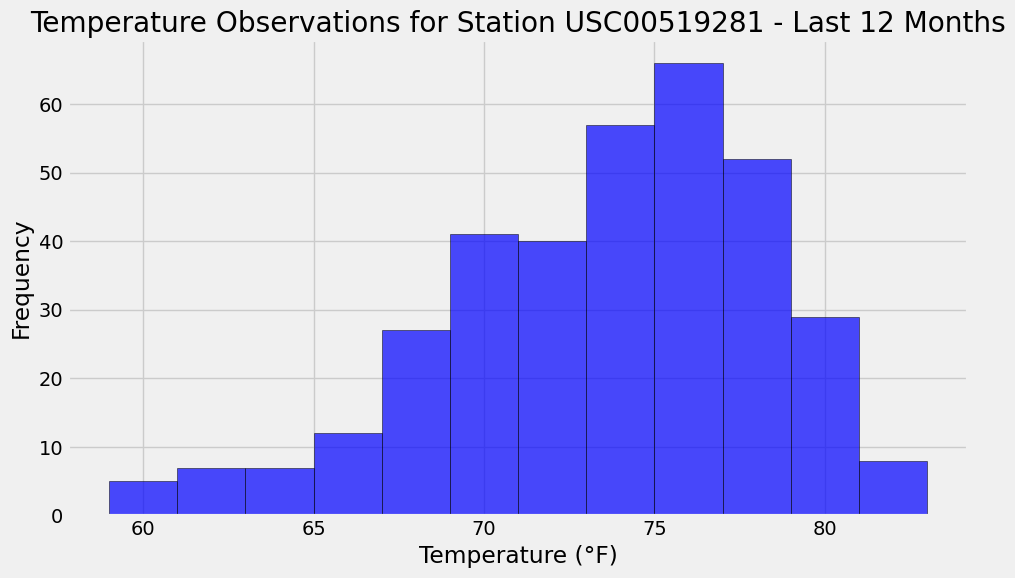

In [44]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_station_id = most_active_stations[0][0]

one_year_ago = dt.datetime.strptime(most_recent_data, "%Y-%m-%d") - dt.timedelta(days=365)

temperature_data = (
    session.query(Measurement.tobs)
    .filter(Measurement.station == most_active_station_id)
    .filter(Measurement.date >= one_year_ago)
    .order_by(Measurement.date)
    .all()
)

temperature_df = pd.DataFrame(temperature_data, columns=['temperature'])

plt.figure(figsize=(10, 6))
plt.hist(temperature_df['temperature'], bins=12, color='blue', edgecolor='black', alpha=0.7)
plt.title(f"Temperature Observations for Station {most_active_station_id} - Last 12 Months")
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()


# Close Session

In [45]:
# Close Session
session.close()